In [6]:
from jax import random as  jr
from jax import numpy as jnp
from jax import jit
from itertools import count

from ssm_jax.linear_gaussian_ssm.inference import lgssm_smoother
from ssm_jax.linear_gaussian_ssm.models.linear_gaussian_ssm_conjugate import LinearGaussianConjugateSSM

In [ ]:

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = [16, 9]

### Generate synthetic data and initialize parameters by running MAP

In [7]:
from itertools import count
state_dim = 2
emission_dim = 10
num_timesteps = 100

keys = map(jr.PRNGKey, count())

true_model = LinearGaussianConjugateSSM.random_initialization(next(keys), state_dim, emission_dim)

true_states, emissions = true_model.sample(next(keys), num_timesteps)

num_iters = 100
test_model = LinearGaussianConjugateSSM.random_initialization(next(keys), state_dim, emission_dim)
marginal_lls = test_model.fit_em(jnp.array([emissions]), num_iters=num_iters, method='MAP')

# Compute predicted emissions
posterior = test_model.smoother(emissions)
smoothed_emissions = posterior.smoothed_means @ test_model.emission_matrix.value.T \
    + test_model.emission_bias.value
smoothed_emissions_cov = (
    test_model.emission_matrix.value @ posterior.smoothed_covariances @ test_model.emission_matrix.value.T
    + test_model.emission_covariance.value)
smoothed_emissions_std = jnp.sqrt(
    jnp.array([smoothed_emissions_cov[:, i, i] for i in range(emission_dim)]))


100%|██████████| 100/100 [00:00<00:00, 146.83it/s]


In [ ]:

spc = 3
plt.figure(figsize=(10, 4))
for i in range(emission_dim):
    plt.plot(emissions[:, i] + spc * i, "--k", label="observed" if i == 0 else None)
    ln = plt.plot(smoothed_emissions[:, i] + spc * i,
                  label="smoothed" if i == 0 else None)[0]
    plt.fill_between(
        jnp.arange(num_timesteps),
        spc * i + smoothed_emissions[:, i] - 2 * jnp.sqrt(smoothed_emissions_std[i]),
        spc * i + smoothed_emissions[:, i] + 2 * jnp.sqrt(smoothed_emissions_std[i]),
        color=ln.get_color(),
        alpha=0.25,
    )
plt.xlabel("time")
plt.xlim(0, num_timesteps - 1)
plt.ylabel("true and predicted emissions")
plt.legend()

### Blocked Gibbs for LiearGaussianConjugateSSM

  0%|          | 0/500 [00:00<?, ?it/s]

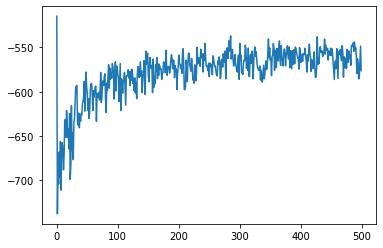

In [4]:
lls, param_samples = test_model.fit_blocked_gibbs(next(keys), sample_size=500, emissions=emissions)

plt.plot(lls)

In [5]:
@jit
def smooth_emission(params):
    posterior = lgssm_smoother(params, emissions)
    return posterior.smoothed_means @ params.emission_matrix.T + params.emission_bias

smoothed_emissions = jnp.array([smooth_emission(params) for params in param_samples])
smoothed_emissions_means = smoothed_emissions.mean(axis=0)
smoothed_emissions_stds = jnp.std(smoothed_emissions, axis=0)

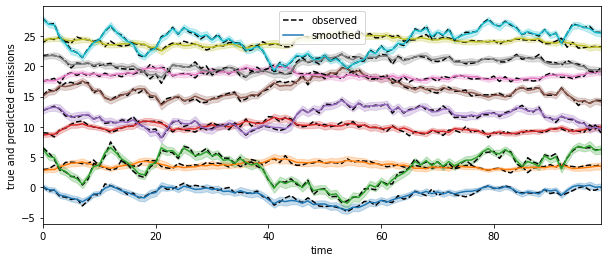

In [6]:
spc = 3
plt.figure(figsize=(10, 4))
for i in range(emission_dim):
    plt.plot(emissions[:, i] + spc * i, "--k", label="observed" if i == 0 else None)
    ln = plt.plot(smoothed_emissions_means[:, i] + spc * i,
                  label="smoothed" if i == 0 else None)[0]
    plt.fill_between(
        jnp.arange(num_timesteps),
        spc * i + smoothed_emissions_means[:, i] - 2 * jnp.sqrt(smoothed_emissions_stds[:, i]),
        spc * i + smoothed_emissions_means[:, i] + 2 * jnp.sqrt(smoothed_emissions_stds[:, i]),
        color=ln.get_color(),
        alpha=0.25,
    )
plt.xlabel("time")
plt.xlim(0, num_timesteps - 1)
plt.ylabel("true and predicted emissions")
plt.legend()